<a href="https://colab.research.google.com/github/lisaong/diec/blob/day4_training/edge_online_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Edge Online Learning

In this notebook, we will train a simple model that will be updated on the device using incoming data.

Tensorflow Lite does not support training on device CPU (yet), so we have to use the full version of Tensorflow. The implication is that models should be simple so that incremental training is not prohibitively expensive on the device.

1. Train simple model incrementally using Keras (Tensorflow backend)
2. Deploy full Tensorflow model on Raspberry Pi 3
3. Continue training with incoming data on Raspberry Pi 3

The model we will train is a binary classification gesture detector. The gesture data collection is covered separately. This notebook covers the machine learning and deployment portions.

The gesture data consists of accelerometer and compass readings collected from the BBC micro:bit. The target is True or False, depending on whether the gesture is happening.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

## Load initial dataset

An initial dataset is used to create a model. Load the dataset from our github repository.

In [4]:
url = 'https://raw.githubusercontent.com/lisaong/diec/master/day4/data.csv'
df = pd.read_csv(url, names=['Gesture', 'AccX', 'AccY', 'AccZ', 'Heading'])
df.head()

,Gesture,AccX,AccY,AccZ,Heading
0,False,28,132,-1008,80
1,False,32,132,-1028,80
2,False,28,132,-1020,80
3,False,28,132,-1020,80
4,False,28,128,-1008,81


In [15]:
# convert True to 1 and False to 0
# in this case we are just converting boolean types
# if converting non boolean types, use df['Gesture'].map(...)
df['Gesture_enc'] = df['Gesture'].astype('int8')
df.head()

,Gesture,AccX,AccY,AccZ,Heading,Gesture_enc
0,False,28,132,-1008,80,0
1,False,32,132,-1028,80,0
2,False,28,132,-1020,80,0
3,False,28,132,-1020,80,0
4,False,28,128,-1008,81,0


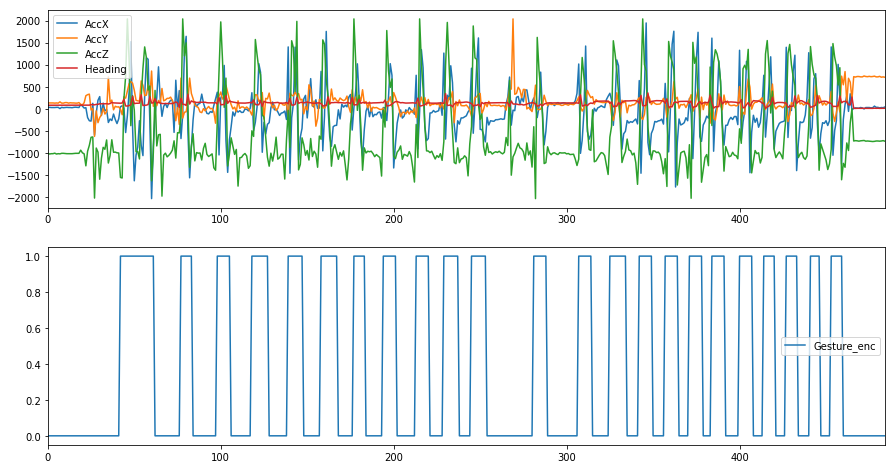

In [25]:
# plot the data, coloured based on whether gesture is recognized

fig, ax = plt.subplots(figsize=(15, 8), nrows=2)

df[['AccX', 'AccY', 'AccZ', 'Heading']].plot(ax=ax[0])
df[['Gesture_enc']].plot(ax=ax[1])
plt.show()

In [32]:
# scale the data and plot again to see more patterns

scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(df[['AccX', 'AccY', 'AccZ', 'Heading']])

scaled_df = pd.DataFrame(scaled_data,
                         columns=['AccX_scaled', 'AccY_scaled', 'AccZ_scaled', 'Heading_scaled'])
scaled_df.head()

,AccX_scaled,AccY_scaled,AccZ_scaled,Heading_scaled
0,0.037111,-0.430285,-0.494118,-0.589744
1,0.039117,-0.430285,-0.503922,-0.589744
2,0.037111,-0.430285,-0.500000,-0.589744
3,0.037111,-0.430285,-0.500000,-0.589744
4,0.037111,-0.433283,-0.494118,-0.584046


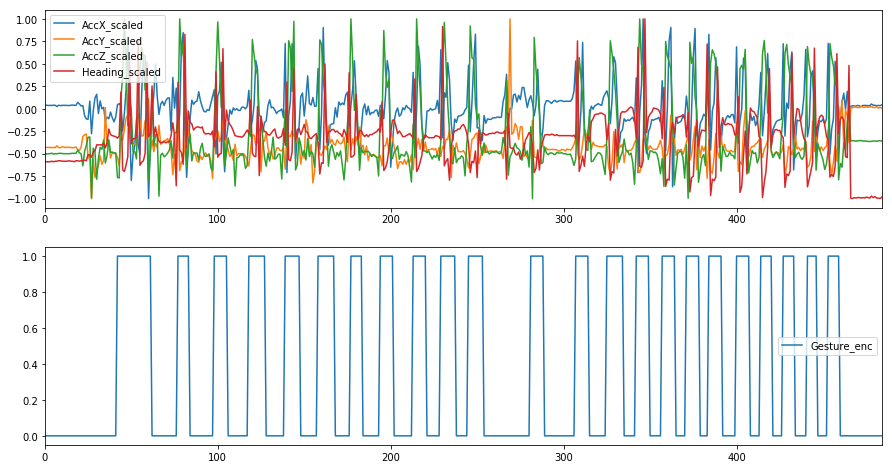

In [34]:
# plot the data, coloured based on whether gesture is recognized

fig, ax = plt.subplots(figsize=(15, 8), nrows=2)

scaled_df.plot(ax=ax[0])
df[['Gesture_enc']].plot(ax=ax[1])
plt.show()

## Preparing data for training

From the plot above, the spikes seem to line up with the gestures. The width of each spike looks to be about 20 samples.

Let's apply windowing so that the past "window" of samples will be used for prediction. This is a multi-variate time series dataset. 

In [36]:
# convert the time series so that each entry contains a series of timesteps.
# Before: rows, features
# After: rows, timesteps, features
# Note that some rows will be removed because we are taking a window of values.

timesteps = 20

# we will use the scaled version of the features
print('Before', scaled_df.shape) # (rows, features)

rolling_indexes = [(range(i, i+timesteps))
                   for i in range(scaled_df.shape[0]-timesteps)]

X_sequence = np.take(scaled_df.values, rolling_indexes, axis=0)
print('After', X_sequence.shape) # (rows, timesteps, features)

Before (485, 4)
After (465, 20, 4)


In [37]:
# shift y down by 1 value so that we are predicting the future
# make sure y is the same length as X_sequence

target = 'Gesture_enc'
print('Before', df[target].shape)
y = df[target][1:X_sequence.shape[0]+1].values
print('After', y.shape)

Before (485,)
After (465,)


In [40]:
# create training and validation set
X_train, X_val, y_train, y_val = train_test_split(X_sequence, y, test_size=0.1,
                                                  stratify=y)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((418, 20, 4), (47, 20, 4), (418,), (47,))